#Estudo sobre o emprego de Técnicas de **Machine Learning**
Este estudo, para tanto, implicará reunir de dados de natureza sócioeconômica com o fim de verificar a relação entre esses e a covid-19, no ambiente dos municípios brasileiros

##1. **Preparação** do Ambiente

In [1]:
### Montar o drive com os arquivos de dados

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [208]:
### Realizar atualizações e carregamento de libs

!pip install --upgrade scikit-learn
!pip install --upgrade pivottablejs

import zipfile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import StratifiedKFold, KFold, StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree import plot_tree
import joblib

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, chi2

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

# Rich visual representation of estimators (new 0.23.2)
from sklearn import set_config
set_config(display='diagram')

from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier


Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.23.2)
Requirement already up-to-date: pivottablejs in /usr/local/lib/python3.6/dist-packages (0.9.0)


##2. **Carregamento e Preparação** do dataset

In [155]:
### Carregar o dataset e exibir infos necessarias a sua análise e preparação
###

DIR_BASE = '/content/drive/MyDrive/Database/COVID19'

with zipfile.ZipFile(DIR_BASE+'/dataset_02.zip','r') as zip_ref:
  zip_ref.extractall(DIR_BASE+'/')

df_origin = pd.read_csv(DIR_BASE+'/dataset_02.csv', sep=';')
df_origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4643 entries, 0 to 4642
Data columns (total 58 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   IBGE               4643 non-null   int64  
 1   PMATPUB_EF         4643 non-null   float64
 2   PMATPUB_EM         4643 non-null   float64
 3   DIST_EF_PUB        4643 non-null   float64
 4   DIST_EM_PUB        4643 non-null   float64
 5   IDEB_AI            4643 non-null   float64
 6   IDEB_AF            4643 non-null   float64
 7   DOCSUP_EF_PUB      4643 non-null   float64
 8   DOCSUP_EM_PUB      4643 non-null   float64
 9   TXMOINF            4643 non-null   float64
 10  TXBRUTAMORT        4643 non-null   float64
 11  TXCOBPLP           4643 non-null   float64
 12  PINTERSAP          4643 non-null   float64
 13  PINTERDRSAI        4643 non-null   float64
 14  REN_TRPCBF_D       4643 non-null   float64
 15  REN_TRPCBPC_D      4643 non-null   float64
 16  PDEFAGUA           4643 

In [156]:
### Alguns ajustes - remoção de variáveis que estão relacionadas ao estado, e não
###     ao município
###

df = df_origin.drop(columns=['IBGE', 'municipio', 'Capital', 'ESPVIDA', 'MORT1', 'T_ENV', 'RAZDEP', 'ANOSEST',
       'T_ANALF15M', 'T_ATRASO_2_BASICO', 'T_ATRASO_2_FUND', 'T_FUND15A17',
       'R1040', 'RDPC', 'RDPC1', 'RDPC4', 'RMPOB', 'RPOB', 'PMPOB', 'PPOB', 'estado',
       'GINI', 'IDHM_E', 'IDHM_L', 'IDHM_R', 'IDHM'], errors=True)
df.drop_duplicates(inplace=True)
df = df.astype({ 
  'POP_TOT': float
})
df.columns

Index(['PMATPUB_EF', 'PMATPUB_EM', 'DIST_EF_PUB', 'DIST_EM_PUB', 'IDEB_AI',
       'IDEB_AF', 'DOCSUP_EF_PUB', 'DOCSUP_EM_PUB', 'TXMOINF', 'TXBRUTAMORT',
       'TXCOBPLP', 'PINTERSAP', 'PINTERDRSAI', 'REN_TRPCBF_D', 'REN_TRPCBPC_D',
       'PDEFAGUA', 'PDEFESGOTO', 'PDEFLIXO', 'PDEFSAN', 'PPOB_POS', 'PBF',
       'SNIS_PAGUA', 'PFOCOS', 'POP_TOT', 'casosAcumulado', 'obitosAcumulado',
       'RegMetro', 'Região', 'Porte', 'LON', 'LAT', 'ANNUAL'],
      dtype='object')

In [157]:
df = df[df['Porte'] == 'Pequeno I'] 
df = df[df['RegMetro'] == 'Interior'] 
df = df[(df['Região'] == 'Região Nordeste') | (df['Região'] == 'Região Norte')] 
df.shape

(1134, 32)

In [158]:
### Criando as variáveis que demonstram o grau de incidência e letalidade
###
### Observação: são considerados os casos acumulados até à data de 01 de
###     Novembro de 2020
###

if ('letalidade' in df.columns): 
  df.drop(columns=['letalidade'], inplace=True)
df = df.assign(letalidade="")

df.loc[:, 'letalidade'] = (df['obitosAcumulado']/df['POP_TOT'])

if ('incidencia' in df.columns): 
  df.drop(columns=['incidencia'], inplace=True)
df = df.assign(incidencia="")

df.loc[:, 'incidencia'] = (df['casosAcumulado']/df['POP_TOT'])


In [159]:
### Descrição de quartiles para criar as classes da variáveis alvo a partir das 
###    variaveis da celula anterior
###

print(df['incidencia'].describe())
print()
print(df['letalidade'].describe())

count    1134.000000
mean        0.023643
std         0.021427
min         0.000273
25%         0.009826
50%         0.018123
75%         0.030063
max         0.207346
Name: incidencia, dtype: float64

count    1134.000000
mean        0.000414
std         0.000363
min         0.000000
25%         0.000131
50%         0.000341
75%         0.000617
max         0.002570
Name: letalidade, dtype: float64


In [161]:
### Categorizar o 'Y' (variável alvo) com base os quartiles vistos na célula
###     anterior. 'Y' como relação de casos e óbitos acumulados por total de 
###     população
###

if ('i_t' in df.columns): 
  df.drop(columns=['i_t'], inplace=True)
df = df.assign(i_t="")

df.loc[df['incidencia'] <= 0.009, ('i_t')] = 1
df.loc[(df['incidencia'] > 0.009) & (df['incidencia'] <= 0.018), ('i_t')] = 2
df.loc[(df['incidencia'] > 0.018) & (df['incidencia'] <= 0.030), ('i_t')] = 3
df.loc[df['incidencia'] > 0.030, ('i_t')] = 4

if ('l_t' in df.columns): 
  df.drop(columns=['l_t'], inplace=True)
df = df.assign(l_t="")

df.loc[df['letalidade'] <= 0.0001, ('l_t')] = 1
df.loc[(df['letalidade'] > 0.0001) & (df['letalidade'] <= 0.0003), ('l_t')] = 2
df.loc[(df['letalidade'] > 0.0003) & (df['letalidade'] <= 0.0006), ('l_t')] = 3
df.loc[df['letalidade'] > 0.0006, ('l_t')] = 4

df = df.astype({ 'i_t': int, 'l_t': int })

if ('delta_il' in df.columns): 
  df.drop(columns=['delta_il'], inplace=True)
df = df.assign(delta_il="")

df.loc[:,'delta_il'] = abs(df['i_t'] - df['l_t'])

In [148]:
df.head()

,PMATPUB_EF,PMATPUB_EM,DIST_EF_PUB,DIST_EM_PUB,IDEB_AI,IDEB_AF,DOCSUP_EF_PUB,DOCSUP_EM_PUB,TXMOINF,TXBRUTAMORT,TXCOBPLP,PINTERSAP,PINTERDRSAI,REN_TRPCBF_D,REN_TRPCBPC_D,PDEFAGUA,PDEFESGOTO,PDEFLIXO,PDEFSAN,PPOB_POS,PBF,SNIS_PAGUA,PFOCOS,POP_TOT,casosAcumulado,obitosAcumulado,RegMetro,Região,Porte,LON,LAT,ANNUAL,letalidade,incidencia,i_t,l_t,delta_il
2,100.00,100.00,11.8,27.8,6.1,5.1,73.5,60.7,0.00,4.66,3.31,47.04,7.47,36.76,103.04,64.37,40.09,40.23,17.92,75.32,47.87,85.80,0.06,6224.0,137.0,5.0,Interior,Região Norte,Pequeno I,-60.5446,-13.4951,3831.0,0.000803,0.022012,3,4,1
4,96.31,97.47,15.5,26.9,6.4,5.3,65.8,39.2,3.61,4.52,3.81,37.16,6.46,44.39,172.70,68.13,91.35,11.01,10.22,68.43,46.38,64.95,0.49,17934.0,276.0,6.0,Interior,Região Norte,Pequeno I,-60.8173,-13.1874,3744.0,0.000335,0.015390,2,3,1
5,96.50,100.00,12.6,18.6,6.4,5.0,65.9,66.0,20.58,4.60,6.34,34.49,7.86,20.44,170.99,31.13,95.26,22.30,19.30,63.52,37.19,100.00,0.02,18467.0,251.0,4.0,Interior,Região Norte,Pequeno I,-60.5459,-13.1178,3565.0,0.000217,0.013592,2,2,0
6,100.00,100.00,21.3,31.5,5.7,4.4,55.1,66.8,22.99,3.70,1.47,20.66,2.02,72.80,67.05,75.76,69.03,57.39,49.68,83.85,57.84,76.11,0.16,8659.0,48.0,3.0,Interior,Região Norte,Pequeno I,-60.9421,-12.9982,3660.0,0.000346,0.005543,1,3,2
7,100.00,100.00,26.4,37.2,4.8,5.0,42.7,51.6,32.41,3.39,1.75,31.36,3.58,147.47,97.13,58.68,35.14,32.91,20.78,95.16,87.42,30.27,0.75,17400.0,326.0,6.0,Interior,Região Norte,Pequeno I,-64.2284,-12.4371,3505.0,0.000345,0.018736,3,3,0


In [162]:
### Definindo o Y Categorizado a partir de obitosAcumulado e casosAcumulado,
###    pela tamanho da populacao, segundo critério explicitado no artigo no 
###    medium

if ('Y' in df.columns): 
  df.drop(columns=['Y'], inplace=True)
df = df.assign(Y="")

idy = len(df.columns)-1;
for idx in range(len(df.index)):
  delta_il = df.iloc[idx]['delta_il']
  i_t = df.iloc[idx]['i_t']
  l_t = df.iloc[idx]['l_t']
  if (delta_il == 0 or delta_il == 1):
    if (i_t < l_t):
      df.iloc[idx, idy] = i_t
    elif (i_t > l_t):
      df.iloc[idx, idy] = l_t
    else:
      df.iloc[idx, idy] = i_t
  elif (delta_il == 2):
    if (i_t < l_t):
      df.iloc[idx, idy] = i_t+1
    elif (i_t > l_t):
      df.iloc[idx, idy] = l_t+1
    else:
      df.iloc[idx, idy] = i_t
  elif (delta_il == 3):
    if (i_t < l_t):
      df.iloc[idx, idy] = i_t+2
    elif (i_t > l_t):
      df.iloc[idx, idy] = l_t+2
    else:
      df.iloc[idx, idy] = i_t


In [163]:
df = df.astype({'Y': str})

df['Y'].replace(to_replace = '1', value = 'preparado', inplace = True)
df['Y'].replace(to_replace = '2', value = 'não preparado', inplace = True)
df['Y'].replace(to_replace = '3', value = 'não preparado', inplace = True)
df['Y'].replace(to_replace = '4', value = 'não preparado', inplace = True)

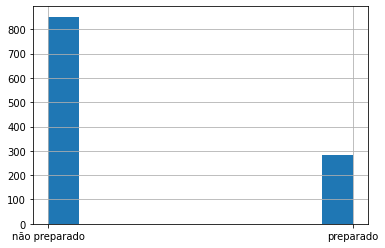

In [164]:
df['Y'].hist()

In [152]:
# from sklearn.utils import resample

# # Separate majority and minority classes
# df_majority = df[df.Y == 'não preparado']
# df_minority = df[df.Y == 'preparado']
 
# # Downsample majority class
# df_majority_downsampled = resample(df_majority, 
#                                  replace=False,    # sample without replacement
#                                  n_samples=282,     # to match minority class
#                                  random_state=123) # reproducible results

# # Combine minority class with downsampled majority class
# df_downsampled = pd.concat([df_majority_downsampled, df_minority])

In [153]:
# df = df_downsampled.copy()
# df_downsampled['Y'].hist()
# print(df_majority_downsampled.shape)
# print(df_minority.shape)
# print(df_downsampled.Y.hist())

In [154]:
### ^
### Há um desbalanceamento. 
# df = df_downsampled.copy()


In [165]:
### Remoção de variáveis que auxiliam a definição do Y
### 

df.drop(columns=['casosAcumulado', 'obitosAcumulado', 'i_t', 'l_t', 'delta_il', 'letalidade', 'incidencia'], inplace=True)

In [166]:
### Definição das classes para extração de novas features e melhorias na 
###     categorização dos dados no dataset, além na normalização dos dados
###     numéricos

#=========================================================
#Custom Transformer that extracts columns passed as argument to its constructor 
class FeatureSelector( BaseEstimator, TransformerMixin ):
    #Class Constructor 
    def __init__( self, feature_names ):
        self.feature_names = feature_names 
    
    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self 
    
    #Method that describes what we need this transformer to do
    def transform( self, X, y = None ):
        return X[ self.feature_names ]

#=========================================================
# Handling categorical features 
class CategoricalTransformer( BaseEstimator, TransformerMixin ):
  # Class constructor method that takes one boolean as its argument
  def __init__(self, new_features=True):
    self.new_features = new_features
    self.colnames = None

  #Return self nothing else to do here    
  def fit( self, X, y = None ):
    return self 

  def get_feature_names(self):
        return self.colnames.tolist()

  # Transformer method we wrote for this transformer 
  def transform(self, X , y = None ):
    df = X.copy()
    
    # customize feature?
    # how can I identify this one? EDA!!!!
    # if self.new_features: 

      # Desnecessário, atividade realizada em notebook anterior

    # update column names
    self.colnames = df.columns      
  
    return df

#=========================================================
# transform numerical features
class NumericalTransformer( BaseEstimator, TransformerMixin ):
  # Class constructor method that takes a model parameter as its argument
  # model 0: minmax
  # model 1: standard
  # model 2: without scaler
  def __init__(self, model = 0):
    self.model = model
    self.colnames = None

  #Return self nothing else to do here    
  def fit( self, X, y = None ):
    return self

  # return columns names after transformation
  def get_feature_names(self):
        return self.colnames 
        
  #Transformer method we wrote for this transformer 
  def transform(self, X , y = None ):
    df = X.copy()
    
    # update columns name
    self.colnames = df.columns.tolist()
    
    # minmax
    if self.model == 0: 
      scaler = MinMaxScaler()
      # transform data
      df = scaler.fit_transform(df)
    elif self.model == 1:
      scaler = StandardScaler()
      # transform data
      df = scaler.fit_transform(df)
    else:
      df = df.values

    return df


In [167]:
### Remoção de Outliners

# Verify if columns[float64] has outliers (with data leakage!!!!!!!)
x = df.select_dtypes("float64")

# identify outlier in the dataset
lof = LocalOutlierFactor()
outlier = lof.fit_predict(x)
mask = outlier != -1

print("df shape [original]: {}".format(df.shape))
print("df shape [outlier removal]: {}".format(df.loc[mask,:].shape))

# municipios with outliner
df_w = df.loc[mask,:].copy()
df_w.head()

df shape [original]: (1134, 31)
df shape [outlier removal]: (1128, 31)


,PMATPUB_EF,PMATPUB_EM,DIST_EF_PUB,DIST_EM_PUB,IDEB_AI,IDEB_AF,DOCSUP_EF_PUB,DOCSUP_EM_PUB,TXMOINF,TXBRUTAMORT,TXCOBPLP,PINTERSAP,PINTERDRSAI,REN_TRPCBF_D,REN_TRPCBPC_D,PDEFAGUA,PDEFESGOTO,PDEFLIXO,PDEFSAN,PPOB_POS,PBF,SNIS_PAGUA,PFOCOS,POP_TOT,RegMetro,Região,Porte,LON,LAT,ANNUAL,Y
2,100.00,100.00,11.8,27.8,6.1,5.1,73.5,60.7,0.00,4.66,3.31,47.04,7.47,36.76,103.04,64.37,40.09,40.23,17.92,75.32,47.87,85.80,0.06,6224.0,Interior,Região Norte,Pequeno I,-60.5446,-13.4951,3831.0,não preparado
4,96.31,97.47,15.5,26.9,6.4,5.3,65.8,39.2,3.61,4.52,3.81,37.16,6.46,44.39,172.70,68.13,91.35,11.01,10.22,68.43,46.38,64.95,0.49,17934.0,Interior,Região Norte,Pequeno I,-60.8173,-13.1874,3744.0,não preparado
5,96.50,100.00,12.6,18.6,6.4,5.0,65.9,66.0,20.58,4.60,6.34,34.49,7.86,20.44,170.99,31.13,95.26,22.30,19.30,63.52,37.19,100.00,0.02,18467.0,Interior,Região Norte,Pequeno I,-60.5459,-13.1178,3565.0,não preparado
6,100.00,100.00,21.3,31.5,5.7,4.4,55.1,66.8,22.99,3.70,1.47,20.66,2.02,72.80,67.05,75.76,69.03,57.39,49.68,83.85,57.84,76.11,0.16,8659.0,Interior,Região Norte,Pequeno I,-60.9421,-12.9982,3660.0,não preparado
7,100.00,100.00,26.4,37.2,4.8,5.0,42.7,51.6,32.41,3.39,1.75,31.36,3.58,147.47,97.13,58.68,35.14,32.91,20.78,95.16,87.42,30.27,0.75,17400.0,Interior,Região Norte,Pequeno I,-64.2284,-12.4371,3505.0,não preparado


#3. Preparando os **Classificadores** (via pipeline)

In [168]:
### split-out train/validation and test dataset

X_train, X_test, y_train, y_test = train_test_split(df_w.drop(labels="Y",axis=1),
                                                    df_w["Y"],
                                                    test_size=0.20,
                                                    random_state=41,
                                                    shuffle=True,
                                                    stratify=df_w["Y"])

In [169]:
### Preparação do Pipeline

# Categrical features to pass down the categorical pipeline 
categorical_features = X_train.select_dtypes("object").columns.to_list()

# Numerical features to pass down the numerical pipeline 
numerical_features = X_train.select_dtypes("float64").columns.to_list()

# Defining the steps in the categorical pipeline 
categorical_pipeline = Pipeline(steps = [('cat_selector', FeatureSelector(categorical_features)),
                                         ('cat_transformer', CategoricalTransformer()),
                                         ('cat_encoder','passthrough')
                                         #('cat_encoder',OneHotEncoder(sparse=False,drop="first"))
                                         ]
                                )

# Defining the steps in the numerical pipeline     
numerical_pipeline = Pipeline(steps = [('num_selector', FeatureSelector(numerical_features)),
                                       ('num_transformer', NumericalTransformer()) 
                                       ]
                              )

# Combining numerical and categorical piepline into one full big pipeline horizontally 
# using FeatureUnion
full_pipeline_preprocessing = FeatureUnion(transformer_list = [('cat_pipeline', categorical_pipeline),
                                                               ('num_pipeline', numerical_pipeline)
                                                               ]
                                           )

In [219]:
### Configuração e execução do Pipeline

seed = 15
num_folds = 10
# scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}
scoring = {'Accuracy': make_scorer(accuracy_score)}

# The full pipeline 
pipe = Pipeline(steps = [('full_pipeline', full_pipeline_preprocessing),
                         ("fs", SelectKBest()),
                         ("classifier", DecisionTreeClassifier())])

# create a dictionary with the hyperparameters
search_space = [
                # {"classifier": [DecisionTreeClassifier()],
                #  "classifier__criterion": ["gini", "entropy"],
                #  "classifier__splitter": ["best", "random"],
                #  "fs__k": [11, 13, 17, 19],
                #  "fs__score_func": [f_classif],  #[f_classif, mutual_info_classif, chi2],
                #  "full_pipeline__cat_pipeline__cat_encoder": [OneHotEncoder(sparse=False,drop="first")], #[OneHotEncoder(sparse=False,drop="first"), OrdinalEncoder()],
                #  "full_pipeline__cat_pipeline__cat_transformer__new_features": [False],
                #  "full_pipeline__num_pipeline__num_transformer__model": [1,0]},
                #  {"classifier": [RandomForestClassifier()],
                #  "classifier__criterion": ["gini","entropy"], 
                #  "classifier__n_estimators": [100, 200, 300, 500],
                #  "fs__k":[11, 13, 17, 19, 23],
                #  "fs__score_func": [mutual_info_classif],
                #  "full_pipeline__cat_pipeline__cat_encoder":[OneHotEncoder(sparse=False,drop="first")]},
                # {"classifier": [AdaBoostClassifier()],
                #  "classifier__n_estimators": [100, 200, 500], 
                #  "classifier__learning_rate": [ 0.01, 0.1, 0.2 ],
                #  "classifier__random_state": [seed],
                #  "fs__k": [11, 13, 17, 19],
                #  "fs__score_func": [f_classif],
                #  "full_pipeline__cat_pipeline__cat_encoder":[OneHotEncoder(sparse=False,drop="first")]},
                {"classifier": [GradientBoostingClassifier()],
                 "classifier__n_estimators": [100, 200, 500], 
                 "classifier__learning_rate": [ 0.01, 0.1, 0.2 ],
                 "classifier__random_state": [seed],
                 "fs__k": [11, 13, 17, 19],
                 "fs__score_func": [f_classif],
                 "full_pipeline__cat_pipeline__cat_encoder":[OneHotEncoder(sparse=False,drop="first")]}
                ]

# create grid search
grid = GridSearchCV(estimator=pipe, 
                    param_grid=search_space,
                    cv=StratifiedKFold(n_splits=num_folds,random_state=seed,shuffle=True),
                    scoring=scoring,
                    return_train_score=True,
                    n_jobs=-1,
                    refit="Accuracy",
                    verbose = 1)

### fit grid search
all_models = grid.fit(X_train, y_train)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  4.6min finished


In [220]:
## Verificando o melhor resultado para o modelo

print("Melhor resultado: %f usando %s" % (all_models.best_score_,all_models.best_params_))

Melhor resultado: 0.786068 usando {'classifier': GradientBoostingClassifier(learning_rate=0.01, n_estimators=500,
                           random_state=15), 'classifier__learning_rate': 0.01, 'classifier__n_estimators': 500, 'classifier__random_state': 15, 'fs__k': 17, 'fs__score_func': <function f_classif at 0x7fd19dc52048>, 'full_pipeline__cat_pipeline__cat_encoder': OneHotEncoder(drop='first', sparse=False)}


In [178]:
## Realizando a predição com o X de teste

predict = all_models.predict(X_test)

In [179]:
## Avaliando/Comparando o resultado com o Y de teste

print(accuracy_score(y_test, predict))

0.7743362831858407


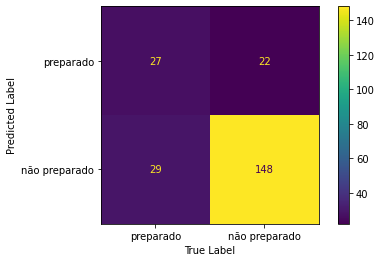

In [181]:
## Desenhando a matriz de confusão em um gráfico

fig, ax = plt.subplots(1,1,figsize=(7,4))

ConfusionMatrixDisplay(confusion_matrix(predict,y_test,labels=["preparado","não preparado"]),
                       display_labels=["preparado","não preparado"]).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
plt.show()

In [ ]:
### ^
### O que se nota acima é apenas são pequenos níveis de dificuldade para a 
###     categorização dos municípios. mais precisamente entre leves e moderados

['RegMetro', 'Região', 'PMATPUB_EF', 'PMATPUB_EM', 'IDEB_AI', 'IDEB_AF', 'DOCSUP_EM_PUB', 'TXMOINF', 'TXBRUTAMORT', 'PINTERSAP', 'PINTERDRSAI', 'REN_TRPCBF_D', 'REN_TRPCBPC_D', 'PDEFAGUA', 'PDEFESGOTO', 'POP_TOT', 'LON']


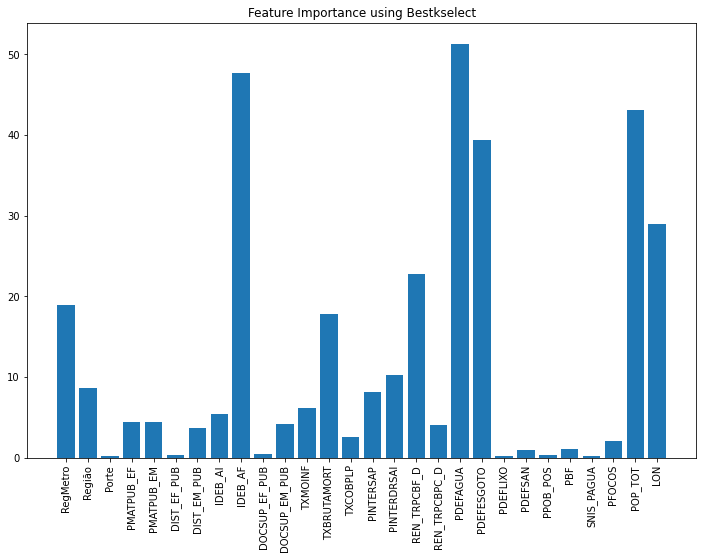

DecisionTreeClassifier(criterion='entropy')


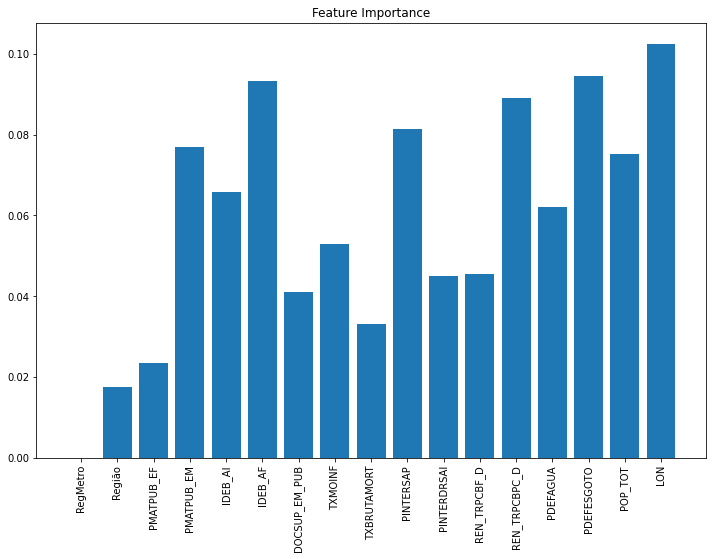

In [182]:
## Investigando de que forma as variáveis contribuíram para o resultado

# columns used in the model (k columns)
features = all_models.best_estimator_.named_steps['fs']

# All information is trackable going back in the Pipeline
# categorical columns
features_full = all_models.best_estimator_.named_steps['full_pipeline']
features_cat = features_full.get_params()["cat_pipeline"]

# numerical columns
features_full.get_params()["num_pipeline"][1].get_feature_names()

# all columns (cat + num)
all_columns = features_cat[1].get_feature_names() + features_full.get_params()["num_pipeline"][1].get_feature_names()


selected_columns = [value for (value, filter) in zip(all_columns, features.get_support()) if filter]
print(selected_columns)

fig, ax = plt.subplots(1,1,figsize=(12,8))
xticks = [x for x in range(len(features.scores_))] 
ax.bar(xticks, features.scores_)
ax.set_xticks(xticks)
ax.set_xticklabels(all_columns,rotation=90)
#ax.set_xticks(ticks=xticks, labels=all_columns,rotation=90,fontsize=15)
ax.set_title("Feature Importance using Bestkselect")
plt.show()

classifier = all_models.best_estimator_.named_steps['classifier']
print(classifier)

# classifier.feature_importances_.shape
fig, ax = plt.subplots(1,1,figsize=(12,8))

xticks = [x for x in range(len(classifier.feature_importances_))] 
ax.bar(xticks, classifier.feature_importances_)
ax.set_xticks(xticks)
ax.set_xticklabels(selected_columns,rotation=90)
#ax.set_xticks(ticks=xticks, labels=all_columns,rotation=90,fontsize=15)
ax.set_title("Feature Importance")
plt.show()